In [2]:
import os
os.getcwd()

'c:\\Users\\bonis\\Documents\\DSI\\cohort_5\\LCR'

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

cancer = pd.read_csv('01_materials/notebooks/dataset/wdbc.csv')

cancer["diagnosis"] = cancer["diagnosis"].replace({
    "M" : "Malignant",
    "B" : "Benign"
})

# set the seed
np.random.seed(1)

#split the data
cancer_train, cancer_test = train_test_split(
    cancer, train_size=0.75, stratify=cancer["diagnosis"], random_state=123
)

print(cancer_train["diagnosis"].value_counts(normalize=True))


diagnosis
Benign       0.626761
Malignant    0.373239
Name: proportion, dtype: float64


In [9]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X=cancer_train[["perimeter_mean", "concavity_mean"]], y=cancer_train["diagnosis"])

cancer_test["predicted"] = knn.predict(cancer_test[["perimeter_mean", "concavity_mean"]])
print(knn.score(
    cancer_test[["perimeter_mean", "concavity_mean"]],
    cancer_test["diagnosis"]
))

print(pd.crosstab(
    cancer_test["diagnosis"],
    cancer_test["predicted"]
))

precision_score(
    y_true=cancer_test["diagnosis"],
    y_pred=cancer_test["predicted"],
    pos_label="Malignant"
)

recall_score(
    y_true=cancer_test["diagnosis"],
    y_pred=cancer_test["predicted"],
    pos_label="Malignant"
)

0.9020979020979021
predicted  Benign  Malignant
diagnosis                   
Benign         85          5
Malignant       9         44


In [21]:
# We're re-using the train_test_split function here in order to split the training data into sub-training and validation sets.
cancer_subtrain, cancer_validation = train_test_split(
    cancer_train, train_size=0.75, stratify=cancer_train["diagnosis"]
)

# fit the model on the sub-training data
knn = KNeighborsClassifier(n_neighbors=3)
X = cancer_subtrain[["perimeter_mean", "concavity_mean"]]
y = cancer_subtrain["diagnosis"]
knn.fit(X, y)

# compute the score on validation data
acc = knn.score(
    cancer_validation[["perimeter_mean", "concavity_mean"]],
    cancer_validation["diagnosis"]
)

returned_dictionary = cross_validate(
    estimator=knn,
    cv=5,    # setting up the cross validation number
    X=X,
    y=y
)

cv_5_df = pd.DataFrame(returned_dictionary)    # Converting it to pandas DataFrame

# Compute mean and standard error of the mean (SEM) for each column
cv_5_metrics = cv_5_df.agg(["mean", "sem"])
cv_5_metrics

,fit_time,score_time,test_score
mean,0.002026,0.005653,0.887153
sem,0.000647,0.000894,0.013425


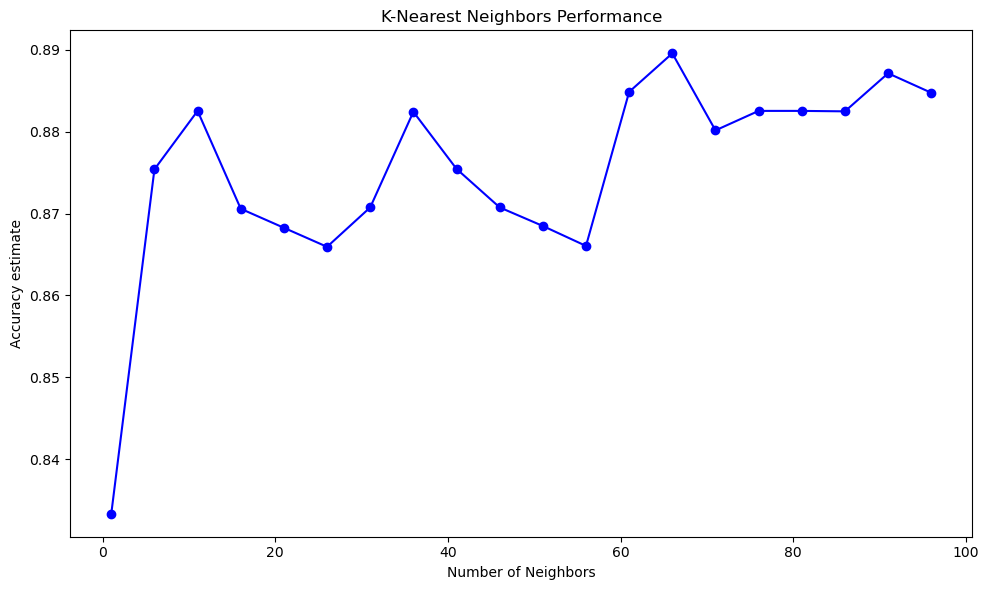

{'n_neighbors': 66}

In [28]:
parameter_grid = {
    "n_neighbors": range(1, 100, 5),
    #"weights" : ['uniform', 'distance']
}

# Encode the target labels
#from sklearn.preprocessing import LabelEncoder
#label_encoder = LabelEncoder()
#cancer_train["diagnosis"] = label_encoder.fit_transform(cancer_train["diagnosis"])  # 0 = 'Benign', 1 = 'Malignant'

cancer_tune_grid = GridSearchCV(
    estimator=knn,
    param_grid=parameter_grid,
    cv=10,
    scoring='accuracy'
    #scoring=['recall','accuracy']
    #refit=False
)

cancer_tune_grid.fit(
    cancer_train[["perimeter_mean", "concavity_mean"]],
    cancer_train["diagnosis"]
)

accuracies_grid = pd.DataFrame(cancer_tune_grid.cv_results_)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot mean test scores with error bars
plt.plot(accuracies_grid['param_n_neighbors'], accuracies_grid['mean_test_score'], '-o', color='blue')

#accuracies_grid['mean_test_score_rolling_avg_10'] = accuracies_grid['mean_test_score'].rolling(10).mean()
#plt.plot(accuracies_grid['param_n_neighbors'], accuracies_grid['mean_test_score_rolling_avg_10'], color='red')

# Add labels and legend
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy estimate')
plt.title('K-Nearest Neighbors Performance')
plt.tight_layout()
plt.show()

cancer_tune_grid.best_params_